In [2]:
# from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from custom_dataloader import replicate_data, replicate_data_single
import matplotlib.pyplot as plt
from PRF import prf

from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay,accuracy_score,f1_score,classification_report
# from sklearn.preprocessing import StandardScaler


# JWST Classification

In [16]:
webb_inp = pd.read_csv('../../NGC_3324/CC_JWST_NIRCAM_MIRI_Full_Dec132022_2pt_vegamag_flux.csv')
all_inp = pd.read_csv('CC_Webb_NIRCam_MIRI_Spitz_2m_w_SPICY_Preds_Dec52022.csv')
print(len(all_inp))

all_inp.columns


346


Index(['Unnamed: 0', 'RA', 'DEC', 'size', 'isophotal_vegamag_f090w',
       'isophotal_vegamag_err_f090w', 'aper30_vegamag_f090w',
       'aper30_vegamag_err_f090w', 'aper50_vegamag_f090w',
       'aper50_vegamag_err_f090w',
       ...
       'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4', 'alpha',
       'Preds', 'SPICY', 'SPICY_Class', 'SPICY_Class_0/1'],
      dtype='object', length=225)

In [17]:
cont = True
amounts_te = []
# 090, 187, 200, 335, 444, 470, 770, 1130, 1280, 1800
inds = (0,4,6,8,12,14,16,18)

bands = [idx for idx in webb_inp.columns.values if (idx[:3].lower() == 'iso'.lower() and idx[10]=='v')]
print(np.array(bands)[np.array(inds)])

input_webb = all_inp[bands].to_numpy()
tar_webb = all_inp[['SPICY_Class_0/1']].to_numpy()
tar_webb[tar_webb==2] = 1

# Choose whether to use RF preds or Preds from SPY-finder
# bands_IR = [idx for idx in all_inp.columns.values if ((idx[:3] == 'mag') or (idx[:5] == 'e_mag'))]
# pred_CC = rf.predict(all_inp[bands_IR].to_numpy())
# pred_CC[pred_CC==2] = 1
pred_CC = tar_webb
def get_best_prf(inds):
    max_f1 = 0.3
    f1scores = []
    for i in np.arange(0,1000,2):
        inp_tr, tar_tr = replicate_data_single(input_webb[:,inds],pred_CC,amounts=[len(pred_CC[pred_CC==0]),len(pred_CC[pred_CC==0])*3],seed=i)
        # webb_inp_tar = np.random.randint(low = 0,high=2,size=webb_inp.shape[0])
        inp_te = webb_inp[np.r_[['RA','DEC','size'],np.array(bands)[np.array(inds)]]].to_numpy()#, tar_te = replicate_data_single(webb_inp[np.r_[['RA','DEC','size'],np.array(bands)[np.array(inds)]]].to_numpy(),webb_inp_tar,amounts=[len(webb_inp_tar[webb_inp_tar==0]),len(webb_inp_tar[webb_inp_tar==1])],seed=i)
        inp_te_radec = inp_te[:,:3]
        inp_te = inp_te[:,3:]


        inp_va, tar_va = replicate_data_single(input_webb[:,inds],pred_CC,amounts=[len(pred_CC[pred_CC==0]),len(pred_CC[pred_CC==1])],seed=i)


        prf_cls = prf(n_estimators=100, bootstrap=False, keep_proba=0.75)
        prf_cls.fit(X=inp_tr, dX=np.array([[0.1]*(int(len(inds)))]*len(tar_tr)), y=tar_tr)

        pred_va = prf_cls.predict(X=inp_va,dX=np.array([[0.1]*(int(len(inds)))]*len(tar_va)))
        f1scores.append(f1_score(tar_va,pred_va,pos_label=0))

        # pred_te = prf_cls.predict(X=inp_te, dX=np.array([[0.1]*(int(len(inds)))]*len(tar_te)))
        # amounts_te.append(len(pred_te[pred_te==0]))

        if (f1_score(tar_va,pred_va,average=None)[0] > max_f1):
            max_prf = prf_cls
            max_f1 = f1_score(tar_va,pred_va,average=None)[0]

            pred_tr = prf_cls.predict(X=inp_tr, dX=np.array([[0.1]*(int(len(inds)))]*len(tar_tr)))
            tar_tr_max, pred_tr_max = tar_tr, pred_tr
            # inp_tr_max, tar_tr_max, pred_tr_max = inp_tr, tar_tr, pred_tr

            # inp_va_max, tar_va_max, pred_va_max = inp_va, tar_va, pred_va

            inp_te_radec_max = inp_te_radec
            inp_te_max = inp_te
            # print(max_f1)
    # print(max_prf.feature_importances_)
    return max_prf, pred_tr_max, tar_tr_max, inp_te_max, inp_te_radec_max, f1scores, max_f1



['isophotal_vegamag_f090w' 'isophotal_vegamag_f200w'
 'isophotal_vegamag_f335m' 'isophotal_vegamag_f444w'
 'isophotal_vegamag_f770w' 'isophotal_vegamag_f1130w'
 'isophotal_vegamag_f1280w' 'isophotal_vegamag_f1800w']


In [18]:
# all_inds = [[0, 2, 4, 6, 8, 10, 12, 14, 16, 18],[2, 4, 6, 8, 10, 12, 14, 16, 18],[0, 4, 6, 8, 10, 12, 14, 16, 18],\
#     [0, 2, 6, 8, 10, 12, 14, 16, 18],[0, 2, 4, 8, 10, 12, 14, 16, 18],[0, 2, 4, 6, 10, 12, 14, 16, 18],[0, 2, 4, 6, 8, 12, 14, 16, 18],\
#         [0, 2, 4, 6, 8, 10, 14, 16, 18],[0, 2, 4, 6, 8, 10, 12, 16, 18],[0, 2, 4, 6, 8, 10, 12, 14, 18],[0, 2, 4, 6, 8, 10, 12, 14, 16],\
#             [0, 4, 6, 8, 12, 14, 16, 18],[0, 2, 4, 6, 8, 10]]
# # all_inds = [[0, 2, 6, 8, 10, 12, 14, 16, 18]]
# arr_rem = ['All bands present', 'F090W', 'F187N', 'F200W', 'F335M', 'F444W', 'F470N', 'F770W', 'F1130W', 'F1280W', 'F1800W',\
#     'N bands removed', 'MIRI bands removed']

# for i, ind in enumerate(all_inds):
#     pred_te_max = np.zeros(600)
#     while len(pred_te_max[pred_te_max==0]) > 500:
#         max_prf, pred_tr_max, tar_tr_max, inp_te_max, inp_te_radec_max, f1scores, max_f1 = get_best_prf(ind)
#         pred_te_max = max_prf.predict(X=inp_te_max, dX=np.array([[0.1]*(int(len(ind)))]*len(tar_te_max)))
#         print(arr_rem[i],'& &',round(max_f1*100,1),'&', len(pred_te_max[pred_te_max==0]),'\\\ ')
#         print(arr_rem[i],'& TR &',round(f1_score(tar_tr_max,pred_tr_max)*100,1),'&', len(pred_tr_max[pred_tr_max==0]),'\\\ ')
#         plt.hist(f1scores,bins=np.arange(0.3,0.9,0.02),histtype='step',label=arr_rem[i])

# plt.xlabel('F1-Score of YSOs')
# plt.legend()

In [20]:
num_yso = []
f1_scores = []
pred_tes = [np.nan]*len(webb_inp)

all_inds = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

for i in np.arange(0,100):
    max_prf, pred_tr_max, tar_tr_max, inp_te_max, inp_te_radec_max, f1scores, max_f1 = get_best_prf(all_inds)
    f1_scores.append(max_f1)
    pred_te_max = max_prf.predict(X=inp_te_max, dX=np.array([[0.1]*(int(len(all_inds)))]*len(inp_te_max)))
    num_yso.append(len(pred_te_max[pred_te_max==0]))
    pred_tes = np.c_[pred_tes,pred_te_max]



In [21]:
# To determine classification, use mean of each row to determine probability of that object being a star. 
# If the probability to be a star is less than 50%, then the object is a YSO with probability 1-mean
# Make two columns: final class, and probability of being that class

# r = np.c_[pred_te_max,[0]*len(pred_te_max),[1]*len(pred_te_max)] # Reminder of how np.c_ works
p_star = np.nanmean(pred_tes,axis=1)
preds = np.zeros(len(p_star))
preds[p_star>0.5] = 1
p_yso = 1-p_star

preds

len(preds[preds==0])

42

In [22]:
# Make and save predictions/probabilities in csv
CC_Webb_Classified = pd.DataFrame()

CC_Webb_Classified['RA'] = inp_te_radec_max.transpose()[0]
CC_Webb_Classified['DEC'] = inp_te_radec_max.transpose()[1]
CC_Webb_Classified['size'] = inp_te_radec_max.transpose()[2]
CC_Webb_Classified[np.array(bands)[np.array(ind)]] = inp_te_max
CC_Webb_Classified['Class'] = preds
CC_Webb_Classified['Prob YSO'] = p_yso


In [23]:
# Put NANs back into all_inp

spitzer_bands = [idx for idx in all_inp.columns.values if (idx[:3].lower() == 'mag' or idx[:5].lower() == 'e_mag')]

for i, s in enumerate(spitzer_bands):
    if i%2 == 0:
        s_ind = all_inp[all_inp[s] == max(all_inp[s].values)].index
        all_inp[s].iloc[s_ind] = np.nan
    else:
        # s_ind = all_inp[all_inp[s] == max(all_inp[s].values)]
        all_inp[s].iloc[s_ind] = np.nan


all_inp 

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/1530893763.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_inp[s].iloc[s_ind] = np.nan
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/1530893763.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_inp[s].iloc[s_ind] = np.nan


Unnamed: 0          RA        DEC      size  isophotal_vegamag_f090w  \
0             0  159.225740 -58.614791  0.001592                      NaN   
1             1  159.267083 -58.580510  0.000903                13.018948   
2             2  159.178134 -58.562264  0.001339                10.788224   
3             3  159.250975 -58.592640  0.000799                12.768613   
4             4  159.225224 -58.626385  0.002905                      NaN   
..          ...         ...        ...       ...                      ...   
341         341  159.250262 -58.591194  0.000058                      NaN   
342         342  159.276678 -58.588333  0.000087                      NaN   
343         343  159.194087 -58.634834  0.000113                      NaN   
344         344  159.196622 -58.636152  0.000089                      NaN   
345         345  159.250120 -58.596046  0.000072                      NaN   

     isophotal_vegamag_err_f090w  aper30_vegamag_f090w  \
0                            NaN                   NaN   
1                       9.499820             26.101178   
2                       8.623969             18.994490   
3                       8.807995             26.707967   
4                            NaN                   NaN   
..                           ...                   ...   
341                          NaN                   NaN   
342                          NaN                   NaN   
343                          NaN                   NaN   
344                          NaN                   NaN   
345                          NaN                   NaN   

     aper30_vegamag_err_f090w  aper50_vegamag_f090w  aper50_vegamag_err_f090w  \
0                         NaN                   NaN                       NaN   
1                   16.808694             25.728937                 17.127796   
2                   13.663846             17.438456                 12.872796   
3                   16.277158             25.058784                 15.366050   
4                         NaN                   NaN                       NaN   
..                        ...                   ...                       ...   
341                       NaN                   NaN                       NaN   
342                       NaN                   NaN                       NaN   
343                       NaN                   NaN                       NaN   
344                       NaN                   NaN                       NaN   
345                       NaN                   NaN                       NaN   

     ...  e_mag_IR2  mag_IR3  e_mag_IR3  mag_IR4  e_mag_IR4     alpha  Preds  \
0    ...      0.155   10.058      0.199      NaN        NaN -13.66696    2.0   
1    ...      0.049    6.399      0.033    5.622      0.024  -0.76836    0.0   
2    ...      0.054    7.715      0.037    7.602      0.030  -2.50840    0.0   
3    ...      0.042    7.082      0.033    5.858      0.025   0.55512    0.0   
4    ...      0.107   11.619      0.182      NaN        NaN -12.95520    2.0   
..   ...        ...      ...        ...      ...        ...       ...    ...   
341  ...      0.075   11.087      0.080    9.977      0.075  -0.17304    0.0   
342  ...      0.096   10.969      0.095   10.266      0.056  -1.23412    0.0   
343  ...      0.150      NaN        NaN      NaN        NaN -11.20696    2.0   
344  ...      0.086    9.799      0.064    8.857      0.066   0.62892    0.0   
345  ...      0.116      NaN        NaN      NaN        NaN -11.65304    2.0   

      SPICY  SPICY_Class  SPICY_Class_0/1  
0       NaN          NaN                1  
1       NaN          NaN                1  
2       NaN          NaN                1  
3    7461.0    FS                       0  
4    7441.0    ClassI                   0  
..      ...          ...              ...  
341  7461.0    FS                       0  
342  7475.0    ClassII                  0  
343     NaN          NaN                1  
344  7423

In [24]:
from astropy.coordinates import match_coordinates_sky,SkyCoord
import astropy.units as u
# ADD SPICY PREDS
j_sky = SkyCoord(CC_Webb_Classified.RA*u.deg,CC_Webb_Classified.DEC*u.deg)
sp_sky = SkyCoord(all_inp.RA*u.deg, all_inp.DEC*u.deg)

idx, sep2d, _ = match_coordinates_sky(j_sky, sp_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < np.array(CC_Webb_Classified['size']*3)*u.deg

print(np.count_nonzero(sep_constraint))

j_matches = CC_Webb_Classified[sep_constraint]
s2_matches = all_inp.iloc[idx[sep_constraint]]

j_matches.reset_index(inplace=True)
s2_matches.reset_index(drop=True,inplace=True)



spitzer_bands = [idx for idx in s2_matches.columns.values if (idx[:3].lower() == 'mag' or idx[:5].lower() == 'e_mag')]
spitzer_bands.append('SPICY_Class_0/1')
spitzer_bands.append('SPICY')
spitzer_bands.append('SPICY_Class')

jwst_spitz_spicy_cat = pd.concat([j_matches,s2_matches[spitzer_bands]],axis=1)
# print(jwst_spitz_spicy_cat)
spicy_df_to_add = pd.DataFrame(data=jwst_spitz_spicy_cat[spitzer_bands].values,columns=spitzer_bands,index=jwst_spitz_spicy_cat['index'])


# jwst_spitz_spicy_cat = pd.concat([j_matches,s2_matches[['SPICY_Class_0/1']]],axis=1)

# spicy_df_to_add = pd.DataFrame(data={'SPICY_Class_0/1':jwst_spitz_spicy_cat['SPICY_Class_0/1'].values},index=jwst_spitz_spicy_cat['index'])
CC_Webb_Classified = pd.concat([CC_Webb_Classified,spicy_df_to_add],axis=1)


CC_Webb_Classified.to_csv('CC_Webb_Predictions_Prob.csv')

364


Mean number of YSOs: 295.59 Median number of YSOs: 57.0
Mean F1-Score: 0.8092011352144459 Median F1-Score: 0.8070175438596492 Standard deviation F1-Score: 0.013333665683135763
Percent of number of objects above 100: 19


Text(0, 0.5, 'F1-Score of YSOs')

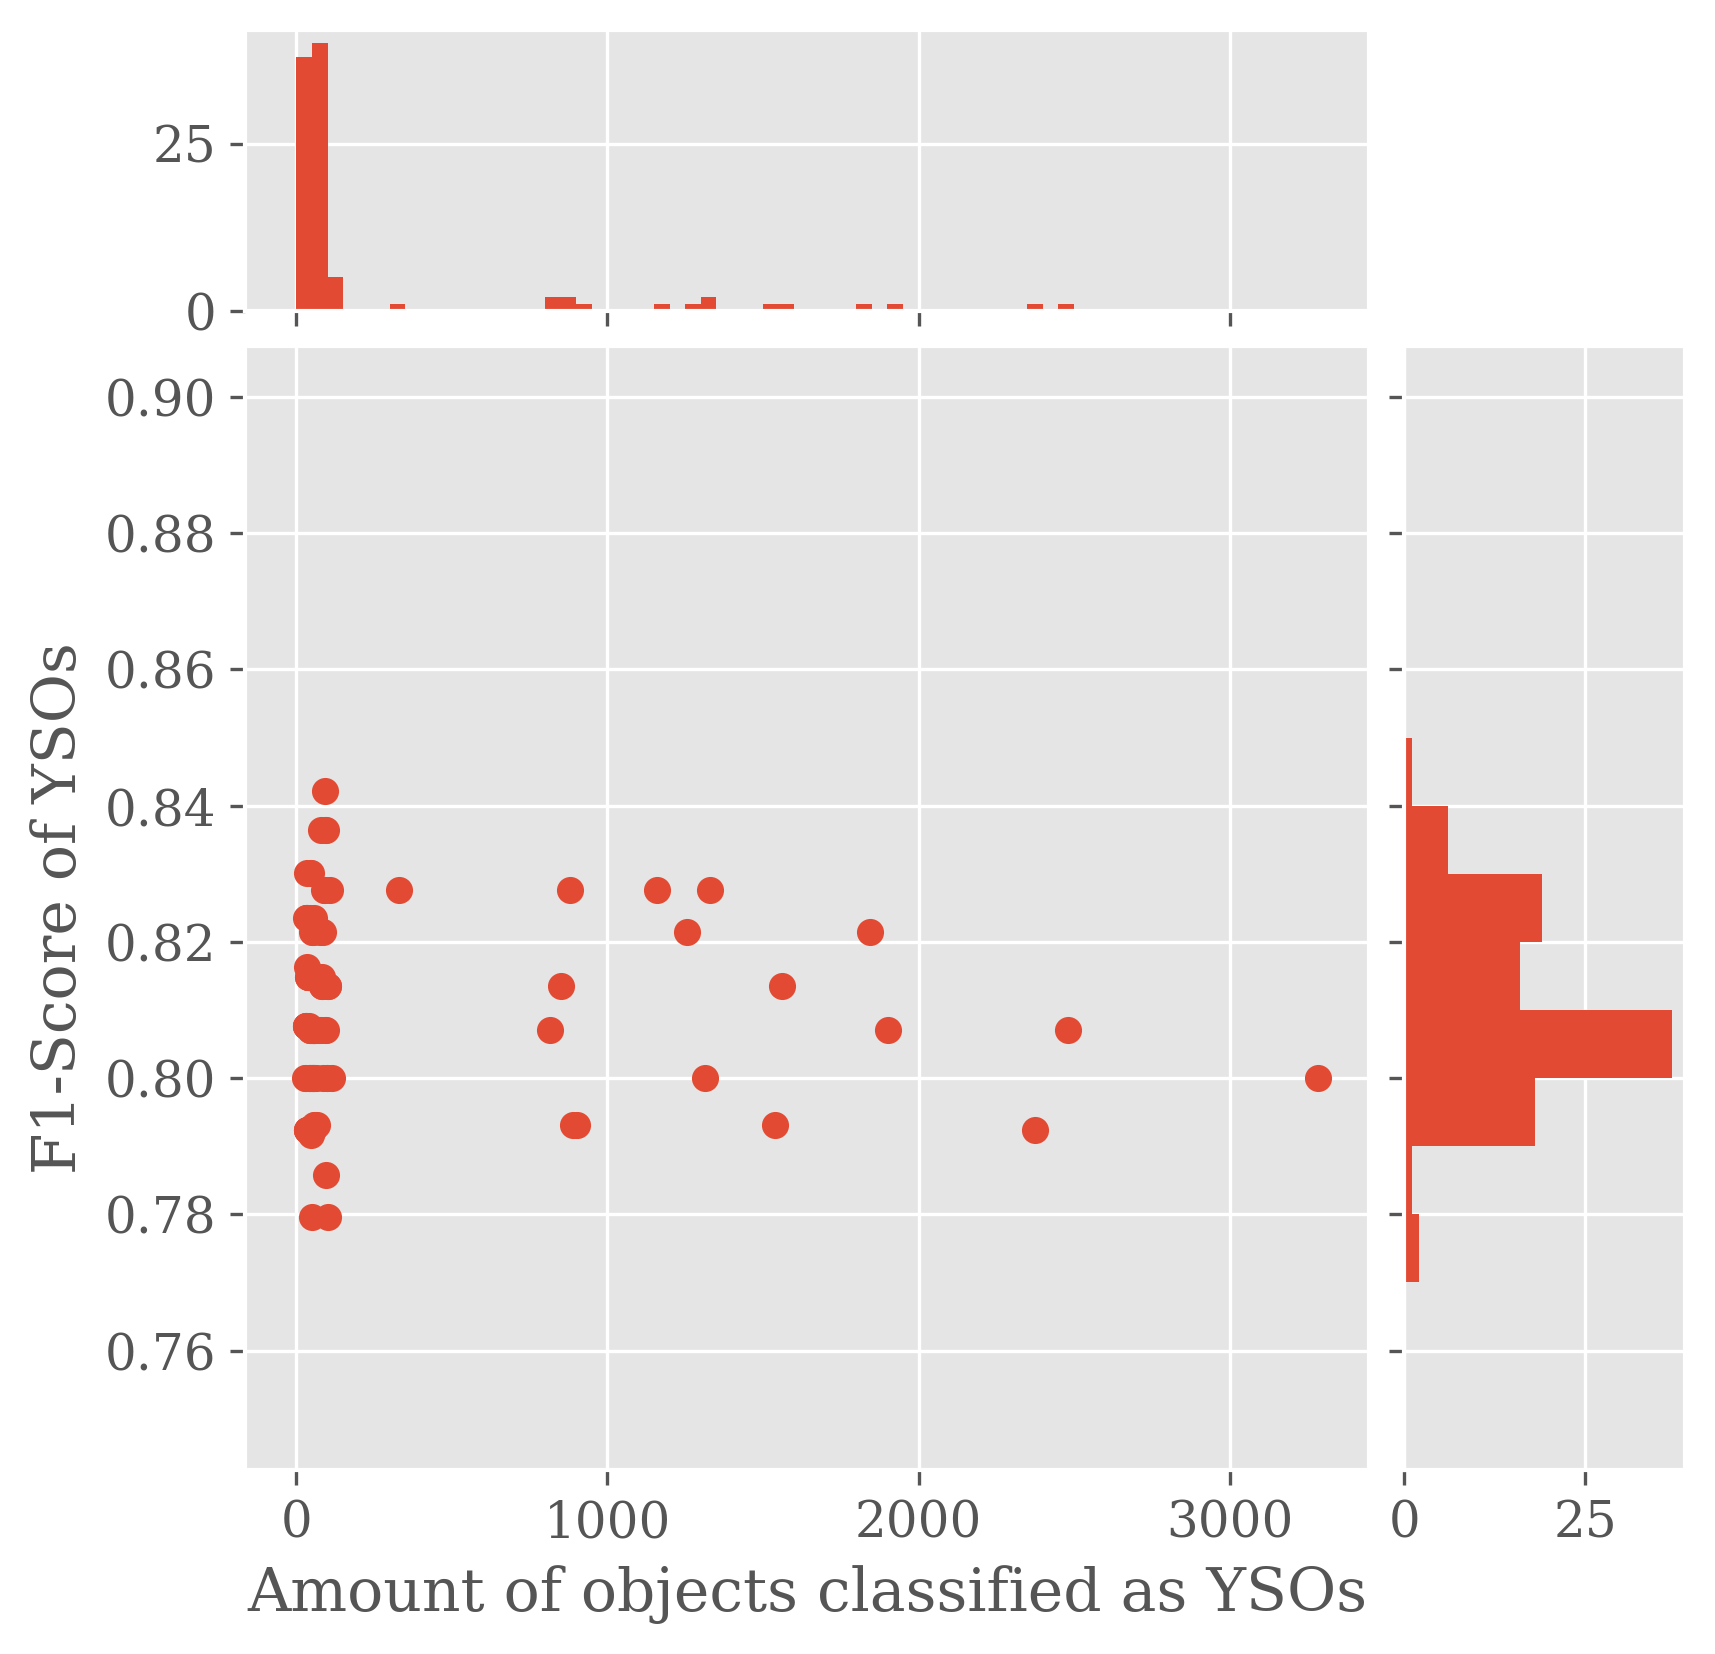

In [30]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
# Scatter plot with hists
print('Mean number of YSOs:',np.mean(num_yso), 'Median number of YSOs:', np.median(num_yso))
print('Mean F1-Score:',np.mean(f1_scores), 'Median F1-Score:', np.median(f1_scores), 'Standard deviation F1-Score:', np.std(f1_scores))
print("Percent of number of objects above 100:",len(np.array(num_yso)[np.array(num_yso)>100]))
fig = plt.figure(figsize=(6, 6),dpi=300)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
# scatter_hist(amounts_te, f1scores, ax, ax_histx, ax_histy)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(num_yso,bins=np.arange(0,3000,50))#
ax_histy.hist(f1_scores,bins=np.arange(0.75,0.9,0.01), orientation='horizontal')
ax.scatter(num_yso,f1_scores)
ax.set_xlabel('Amount of objects classified as YSOs')
ax.set_ylabel('F1-Score of YSOs')
# ax.set_xscale('log')

0.9881305637982195
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        25
           1       0.99      0.98      0.99       339

    accuracy                           0.98       364
   macro avg       0.89      0.95      0.92       364
weighted avg       0.98      0.98      0.98       364



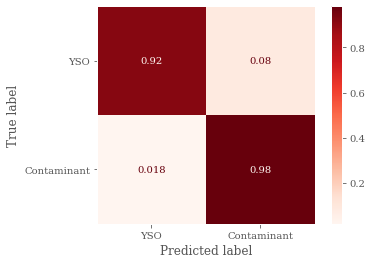

In [50]:
tar_va = CC_Webb_Classified.dropna(subset='SPICY_Class_0/1')[['SPICY_Class_0/1']].values.astype(int)
pred_va = CC_Webb_Classified.dropna(subset='SPICY_Class_0/1')[['Class']].values
ConfusionMatrixDisplay.from_predictions(tar_va,pred_va,cmap='Reds',display_labels=['YSO', 'Contaminant'],normalize='true')
print(f1_score(tar_va,pred_va))
print(classification_report(tar_va,pred_va))
plt.grid(False)
plt.savefig('CM_va_PRF_SPICY_Dec82022.png',dpi=300,facecolor=fig.get_facecolor())

Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


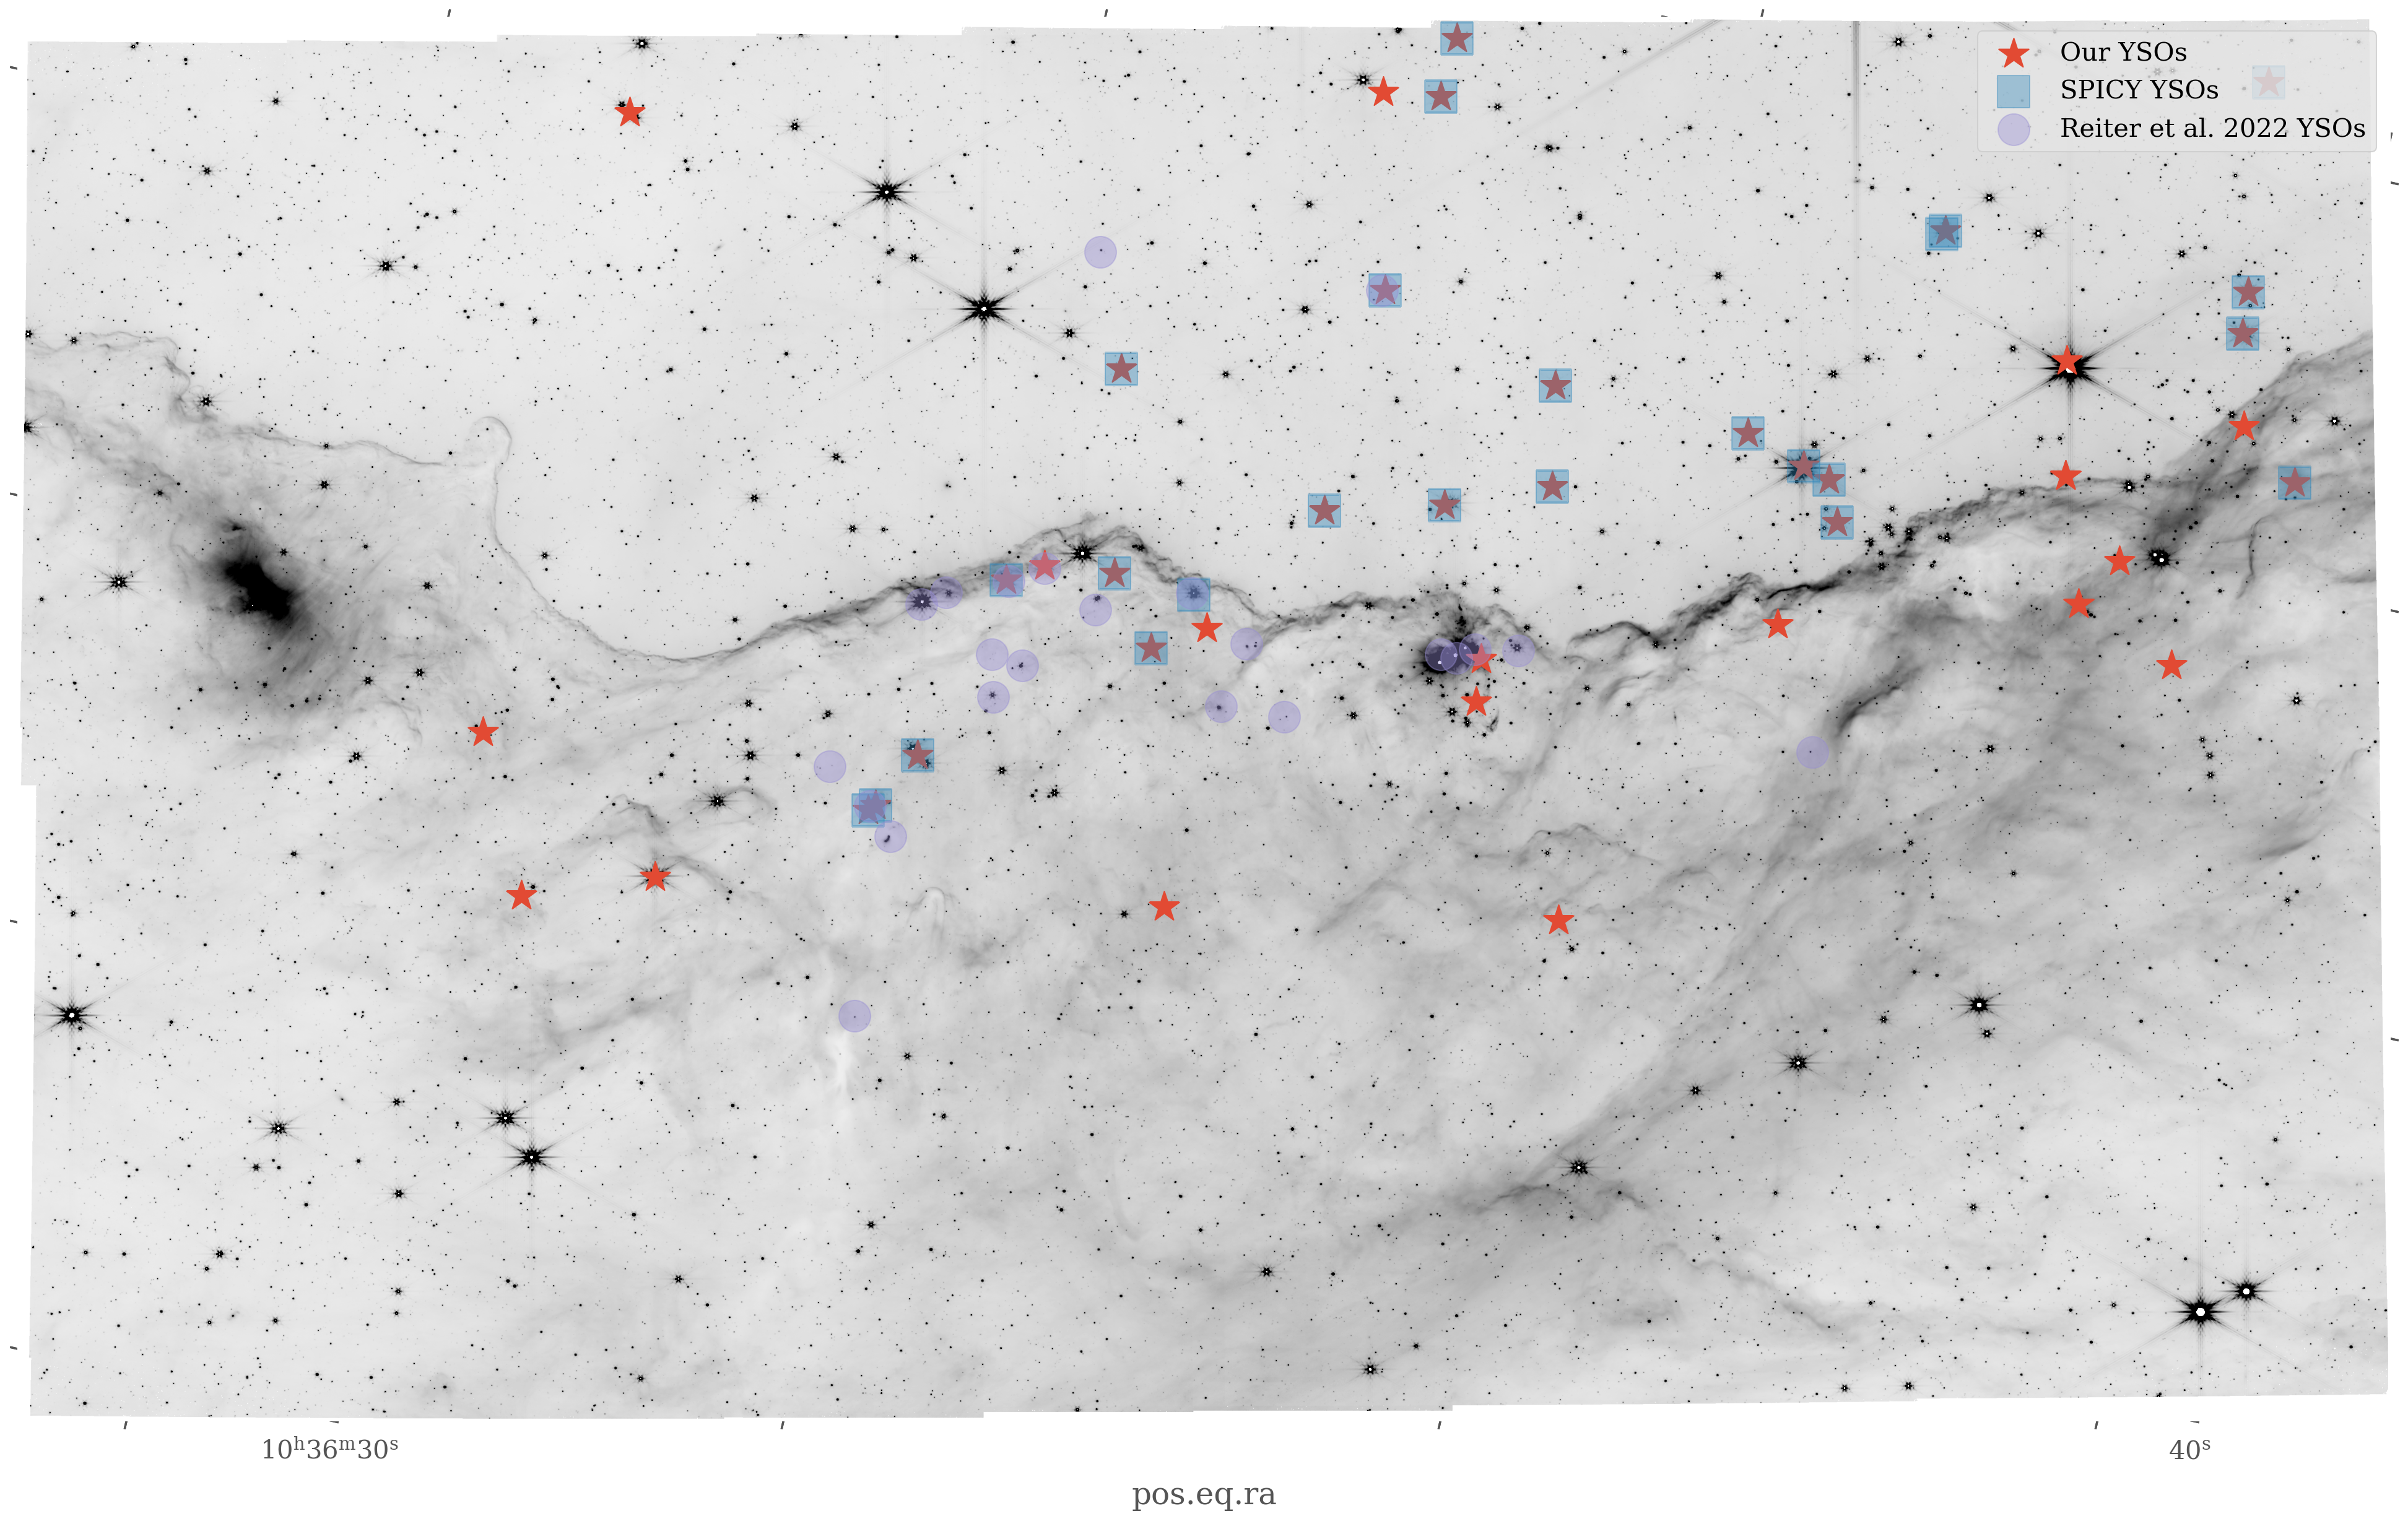

In [95]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u


# Plot image
filter = "f444w"
image_file = f"../../../ngc3324/FITS/JWST_{filter}.fits"


h = fits.getheader(image_file)
f = fits.open(image_file)
wcs = WCS(f[1].header)
# plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14,8),dpi=300)
ax = plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid')
plt.imshow(f[1].data,cmap='gray_r',vmin=0,vmax=20,origin='lower') #vmax =1500 for f1800w
ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()
# plt.colorbar()

# ras, decs = wcs.wcs_pix2world(np.linspace(-500,15000,100), np.linspace(-500,16000,100), 1)
# print(min(ras))



reit = ["10:36:42.3 -58:38:04", "10:36:48.0 -58:38:19", "10:36:47.3 -58:38:10", "10:36:46.7 -58:38:05", "10:36:51.5 -58:37:54", "10:36:50.5 -58:37:52",\
    "10:36:51.4 -58:37:48", "10:36:53.8 -58:37:48", "10:36:51.5 -58:37:10", "10:36:54.2 -58:36:26", "10:36:54.4 -58:36:18", "10:36:54.0 -58:37:20",\
        "10:36:53.6 -58:35:20", "10:36:53.1 -58:37:37", "10:36:53.3 -58:37:54", "10:36:52.7 -58:38:05", "10:36:53.1 -58:37:08", "10:36:51.6 -58:36:58",\
        "10:36:52.3 -58:38:09", "10:36:53.9 -58:36:29", "10:37:01.5 -58:37:51", "10:37:02.1 -58:36:58", "10:36:53.9 -58:36:32"]# End of third row is the end of MHO-only sources
sky_1 = SkyCoord(reit,unit=(u.hourangle, u.deg))
ra_1 = sky_1.ra
dec_1 = sky_1.dec

# reit_eg = ["10:36:53.7 -58:35:47", "10:36:59.5 -58:39:01", "10:37:07.2 -58:35:36", "10:36:55.2 -58:38:09"]
# sky_1 = SkyCoord(reit_eg,unit=(u.hourangle, u.deg))
# ra_eg = sky_1.ra
# dec_eg = sky_1.dec

ra_spicy = CC_Webb_Classified.RA.values[CC_Webb_Classified['SPICY_Class_0/1']==0]
dec_spicy = CC_Webb_Classified.DEC.values[CC_Webb_Classified['SPICY_Class_0/1']==0]


ra_yso = CC_Webb_Classified.RA.values[CC_Webb_Classified.Class == 0]
dec_yso = CC_Webb_Classified.DEC.values[CC_Webb_Classified.Class == 0]

plt.scatter(ra_yso,dec_yso, marker='*', s=150,transform=ax.get_transform('fk5'),label='Our YSOs')
plt.scatter(ra_spicy,dec_spicy, marker='s',s=150, alpha=0.4,transform=ax.get_transform('fk5'),label='SPICY YSOs')
plt.scatter(ra_1,dec_1, marker='o',s=150, alpha=0.4,transform=ax.get_transform('fk5'),label='Reiter et al. 2022 YSOs')
ax.set_ylim(ymax, ymin)
ax.set_xlim(xmax, xmin)
plt.legend(loc=1)
ax.grid(False)
# plt.xticks()
# plt.yticks()
# plt.xlabel('RA')
# plt.ylabel('DEC')

plt.savefig(f"CC_w_Reiter_SPICYtr_Label_{filter}.png",dpi=300)


In [52]:
a = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Correctly classified as YSO
b = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==1].index # Incorrectly classified as YSO
c = CC_Webb_Classified[CC_Webb_Classified.Class!=0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Incorrectly classified as Star
d = CC_Webb_Classified[CC_Webb_Classified.Class!=0][CC_Webb_Classified['SPICY_Class_0/1']==1].index # Correctly classified as Star


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/3283703603.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Correctly classified as YSO
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/3283703603.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==1].index # Incorrectly classified as YSO
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/3283703603.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c = CC_Webb_Classified[CC_Webb_Classified.Class!=0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Incorrectly classified as Star
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/3283703603.py:4: UserWarning: Boolean Series key will be rei

-0.6999720643363637


(array([  7.,  47., 101.,  74.,  55.,   1.,   1.,   0.,   0.,   2.]),
 array([-2.4419868 , -1.86352482, -1.28506284, -0.70660087, -0.12813889,
         0.45032309,  1.02878507,  1.60724705,  2.18570903,  2.76417101,
         3.34263299]),
 <BarContainer object of 10 artists>)

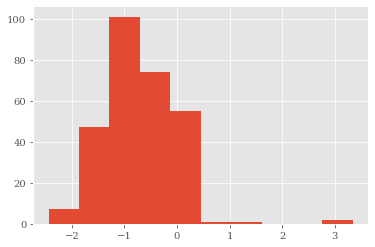

In [53]:
diffs = all_inp.mag_IR2-all_inp.isophotal_vegamag_f444w
print(np.nanmean(diffs))
plt.hist(diffs)

In [54]:
# mu_a = pd.DataFrame([CC_Webb_Classified.iloc[a].mean(skipna=True)])
# sig_a = pd.DataFrame([CC_Webb_Classified.iloc[a].std(skipna=True)])

# mu_b = CC_Webb_Classified.iloc[b].mean()
# sig_b = CC_Webb_Classified.iloc[b].std()

# mu_c = CC_Webb_Classified.iloc[c].mean()
# sig_c = CC_Webb_Classified.iloc[c].std()

# mu_d = CC_Webb_Classified.iloc[d].mean()
# sig_d = CC_Webb_Classified.iloc[d].std()
# print(mu_a)
def sed_plot_mu(ax, ind, cat,title=None,correction=0):
    mu = pd.DataFrame([cat.iloc[ind].mean(skipna=True)])
    sig = pd.DataFrame([cat.iloc[ind].std(skipna=True)])
    # chi2 = chisquare((cat.iloc[ind]+correction).to_numpy()[~np.isnan(cat.iloc[ind]+correction).to_numpy()],np.array(mu)[~np.isnan(np.array(mu))])
    # fig, ax = plt.subplots(figsize=(12,6),dpi=100)
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('ggplot')
    plt.gca().invert_yaxis()

    kwargs = {
        'marker': 'o',
        # 'linestyle': '-.',
        'alpha': 0.2
    }

    webb_bands = [idx for idx in mu.columns.values if (idx[:14].lower() == 'isophotal_vega' and (idx[-9:-6] != 'err' and idx[-15:-12] != 'err'and idx[-10:-7] != 'err'))]
    webb_mic = [int(webb_bands[i].split('f')[-1][:-1])/100 for i in np.arange(0,len(webb_bands))]

    spitz2m_bands = [idx for idx in mu.columns.values if (idx[:3].lower() == 'mag')]
    spitz_mic = [1.235,1.662,2.159,3.6,4.5,5.8,8.0]
    maxes = cat[spitz2m_bands].max().to_numpy()

    all_mic = list(np.r_[webb_mic,spitz_mic]) # Collect list of values for xticks
    del all_mic[4] 
    del all_mic[2]
    del all_mic[1]# Delete the xtick label of 4.44 to avoid over crowding

    ax.plot(np.array([webb_mic]*len(cat.iloc[ind])).transpose(),(cat.iloc[ind][webb_bands].to_numpy()+correction).transpose(),'--',c='r',alpha=0.7)
    ax.plot(webb_mic,mu[webb_bands].to_numpy()[0]+correction,**kwargs,c='r',label='Webb SED')
    ax.fill_between(webb_mic,mu[webb_bands].to_numpy()[0]+correction-sig[webb_bands].to_numpy()[0],mu[webb_bands].to_numpy()[0]+correction+sig[webb_bands].to_numpy()[0],color='r',alpha=0.1)
    ax.plot(np.array([spitz_mic]*len(cat.iloc[ind])).transpose(),(cat.iloc[ind][spitz2m_bands].to_numpy()+correction).transpose(),'--',c='b',alpha=0.5)
    ax.plot(spitz_mic,mu[spitz2m_bands].to_numpy()[0],**kwargs, c='b',label='Spitzer/2MASS SED')
    ax.fill_between(spitz_mic,mu[spitz2m_bands].to_numpy()[0]-sig[spitz2m_bands].to_numpy()[0],mu[spitz2m_bands].to_numpy()[0]+sig[spitz2m_bands].to_numpy()[0],color='b',alpha=0.1)
    ax.plot([],[],alpha=0,label=f'Number: {len(ind)}')
    # ax.plot(spitz_mic,maxes,marker='x',c='b',markersize=10,label='Noise Values')
    # ax.set_xticks(all_mic)
    # plt.plot(label=f'$\chi$ Squared: {chi2}')
    # plt.legend(facecolor='darkgrey', framealpha=1,loc='lower right')
    # plt.xticks(all_mic)
    # plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
    # ax.set_xlabel('Wavelength')
    # ax.set_ylabel('Magnitude (Vega)')
    ax.set_title(title,c='k')

    return ax


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mu = pd.DataFrame([cat.iloc[ind].mean(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/2113043115.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sig = pd.DataFrame([cat.iloc[ind].std(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

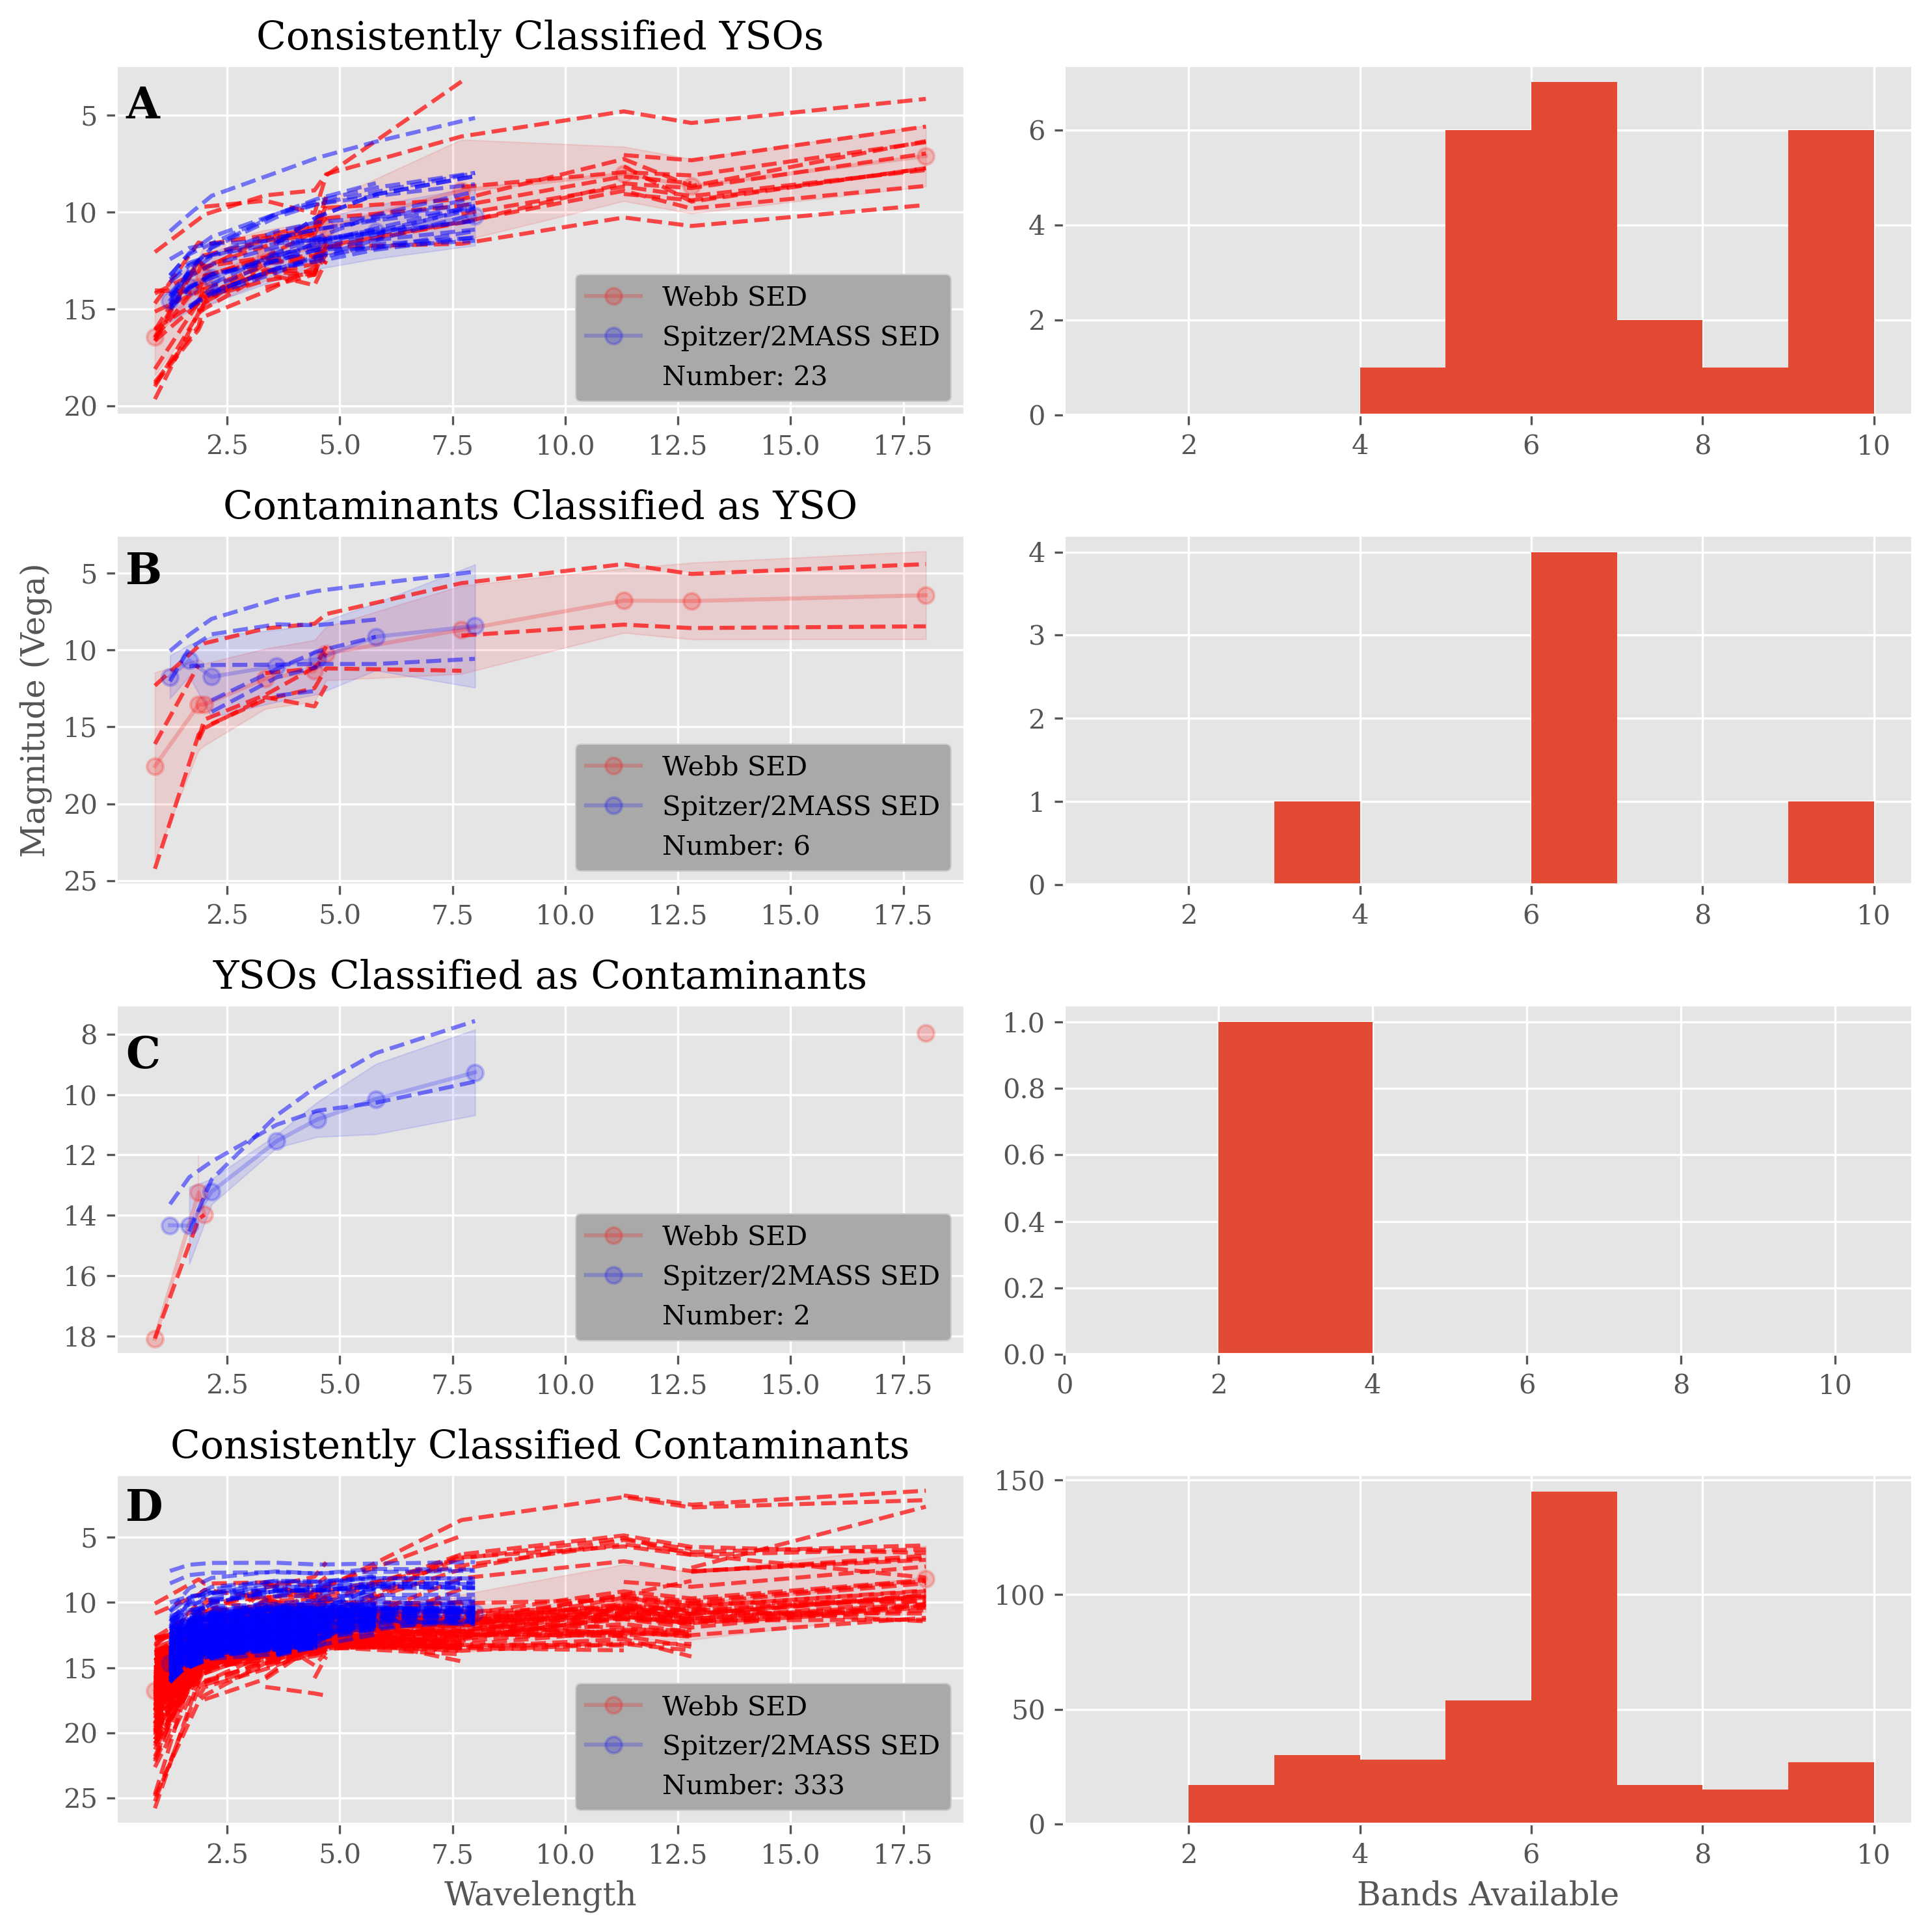

In [55]:
webb_bands = [idx for idx in CC_Webb_Classified.columns.values if (idx[:14].lower() == 'isophotal_vega' and (idx[-9:-6] != 'err' and idx[-15:-12] != 'err'and idx[-10:-7] != 'err'))]
    
fig, axs = plt.subplots(4,2,figsize=(10,10),dpi=300)

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.style.use('ggplot')
plt.tight_layout()
fig.set_tight_layout(True)
# subfigs = fig.subfigures(1, 2)

axs[0][0].invert_yaxis()
axs[1][0].invert_yaxis()
axs[2][0].invert_yaxis()
axs[3][0].invert_yaxis()
# axs[3][1].invert_yaxis()
axs[0][0] = sed_plot_mu(axs[0][0],a,CC_Webb_Classified,title='Consistently Classified YSOs',correction=np.nanmean(diffs))
axs[1][0] = sed_plot_mu(axs[1][0],b,CC_Webb_Classified,title='Contaminants Classified as YSO',correction=np.nanmean(diffs))
axs[2][0] = sed_plot_mu(axs[2][0],c,CC_Webb_Classified,title='YSOs Classified as Contaminants',correction=np.nanmean(diffs))
axs[3][0] = sed_plot_mu(axs[3][0],d,CC_Webb_Classified,title='Consistently Classified Contaminants',correction=np.nanmean(diffs))

ylim_a = axs[0][0].get_ylim()[1]
ylim_b = axs[1][0].get_ylim()[1]
ylim_c = axs[2][0].get_ylim()[1]
ylim_d = axs[3][0].get_ylim()[1]
axs[0][0].text(0.25, ylim_a+1, 'A',  fontsize=16, fontweight='bold', va='top',c='k')
axs[1][0].text(0.25, ylim_b+1, 'B',  fontsize=16, fontweight='bold', va='top',c='k')
axs[2][0].text(0.25, ylim_c+1, 'C',  fontsize=16, fontweight='bold', va='top',c='k')
axs[3][0].text(0.25, ylim_d+1, 'D',  fontsize=16, fontweight='bold', va='top',c='k')


axs[0][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[1][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[2][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[3][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
axs[3][0].set_xlabel('Wavelength')
axs[1][0].set_ylabel('Magnitude (Vega)')


axs[0][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in a],bins=np.arange(1,11,1))
axs[1][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in b],bins=np.arange(1,11,1))
axs[2][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in c],bins=np.arange(1,11,1))
axs[3][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in d],bins=np.arange(1,11,1))
axs[2][1].set_xlim(0,11)
axs[3][1].set_xlabel('Bands Available')

plt.savefig('seds.png',dpi=300)

In [56]:
CC_Webb_Classified.columns
# CC_Webb_Classified[spitzer_bands].div(CC_Webb_Classified.mag_IR2,axis=0)

Index(['RA', 'DEC', 'size', 'isophotal_vegamag_f090w',
       'isophotal_vegamag_f187n', 'isophotal_vegamag_f200w',
       'isophotal_vegamag_f335m', 'isophotal_vegamag_f444w',
       'isophotal_vegamag_f444w-f470n', 'isophotal_vegamag_f770w',
       'isophotal_vegamag_f1130w', 'isophotal_vegamag_f1280w',
       'isophotal_vegamag_f1800w', 'Class', 'Prob YSO', 'mag_J', 'e_mag_J',
       'mag_H', 'e_mag_H', 'mag_Ks', 'e_mag_Ks', 'mag_IR1', 'e_mag_IR1',
       'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4',
       'SPICY_Class_0/1', 'SPICY', 'SPICY_Class'],
      dtype='object')

In [57]:
CC_Webb_Classified_normed = pd.DataFrame()
print((CC_Webb_Classified[webb_bands].div(CC_Webb_Classified.isophotal_vegamag_f444w,axis=0).shape))
# print((CC_Webb_Classified_normed[webb_bands]).shape)
CC_Webb_Classified_normed[webb_bands] = CC_Webb_Classified[webb_bands].div(CC_Webb_Classified.isophotal_vegamag_f444w,axis=0)
CC_Webb_Classified_normed[spitzer_bands[:-3]] = CC_Webb_Classified[spitzer_bands[:-3]].div(CC_Webb_Classified.mag_IR2,axis=0)
CC_Webb_Classified_normed[['SPICY_Class_0/1', 'SPICY','SPICY_Class']] = CC_Webb_Classified[['SPICY_Class_0/1', 'SPICY','SPICY_Class']]
CC_Webb_Classified_normed

(25142, 10)


isophotal_vegamag_f090w  isophotal_vegamag_f187n  \
0                          NaN                      NaN   
1                     1.446602                 1.162049   
2                     1.151152                 1.021389   
3                     1.146335                 0.948365   
4                     1.331705                 1.155225   
...                        ...                      ...   
25137                      NaN                      NaN   
25138                      NaN                      NaN   
25139                      NaN                      NaN   
25140                      NaN                      NaN   
25141                      NaN                      NaN   

       isophotal_vegamag_f200w  isophotal_vegamag_f335m  \
0                     1.308799                 1.097341   
1                     1.141289                 1.034195   
2                     1.036368                 1.018023   
3                     0.983295                 0.972770   
4                     1.130127                 1.027019   
...                        ...                      ...   
25137                      NaN                      NaN   
25138                      NaN                      NaN   
25139                      NaN                      NaN   
25140                      NaN                      NaN   
25141                      NaN                      NaN   

       isophotal_vegamag_f444w  isophotal_vegamag_f444w-f470n  \
0                          1.0                       0.873375   
1                          1.0                       0.930343   
2                          1.0                       0.995536   
3                          1.0                       0.928266   
4                          1.0                       0.913128   
...                        ...                            ...   
25137                      NaN                            NaN   
25138                      NaN                            NaN   
25139                      NaN                            NaN   
25140                      NaN                            NaN   
25141                      NaN                            NaN   

       isophotal_vegamag_f770w  isophotal_vegamag_f1130w  \
0                          NaN                  0.285564   
1                     0.707318                  0.569821   
2                          NaN                       NaN   
3                          NaN                       NaN   
4                     0.710473                  0.575698   
...                        ...                       ...   
25137                      NaN                       NaN   
25138                      NaN                       NaN   
25139                      NaN                       NaN   
25140                      NaN                       NaN   
25141                      NaN                       NaN   

       isophotal_vegamag_f1280w  isophotal_vegamag_f1800w  ... e_mag_IR1  \
0                      0.366690                  0.243859  ...  0.014059   
1                      0.640948                  0.570057  ...  0.006402   
2                           NaN                       NaN  ...       NaN   
3                           NaN                       NaN  ...  0.005133   
4                      0.638221                  0.508713  ...  0.007074   
...                         ...                       ...  ...       ...   
25137                       NaN                       NaN  ...       NaN   
25138                       NaN                       NaN  ...       NaN   
25139                       NaN                       NaN  ...       NaN   
25140                       NaN                       NaN  ...       NaN   
25141                       NaN                       NaN  ...       NaN   

      mag_IR2 e_mag_IR2   mag_IR3 e_mag_IR3   mag_IR4 e_mag_IR4  \
0         1.0  0.013207  0.857021  0.016956       NaN       NaN   
1         1.0  0.007129  0.931034  0.004

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mu = pd.DataFrame([cat.iloc[ind].mean(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/2113043115.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sig = pd.DataFrame([cat.iloc[ind].std(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_28093/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

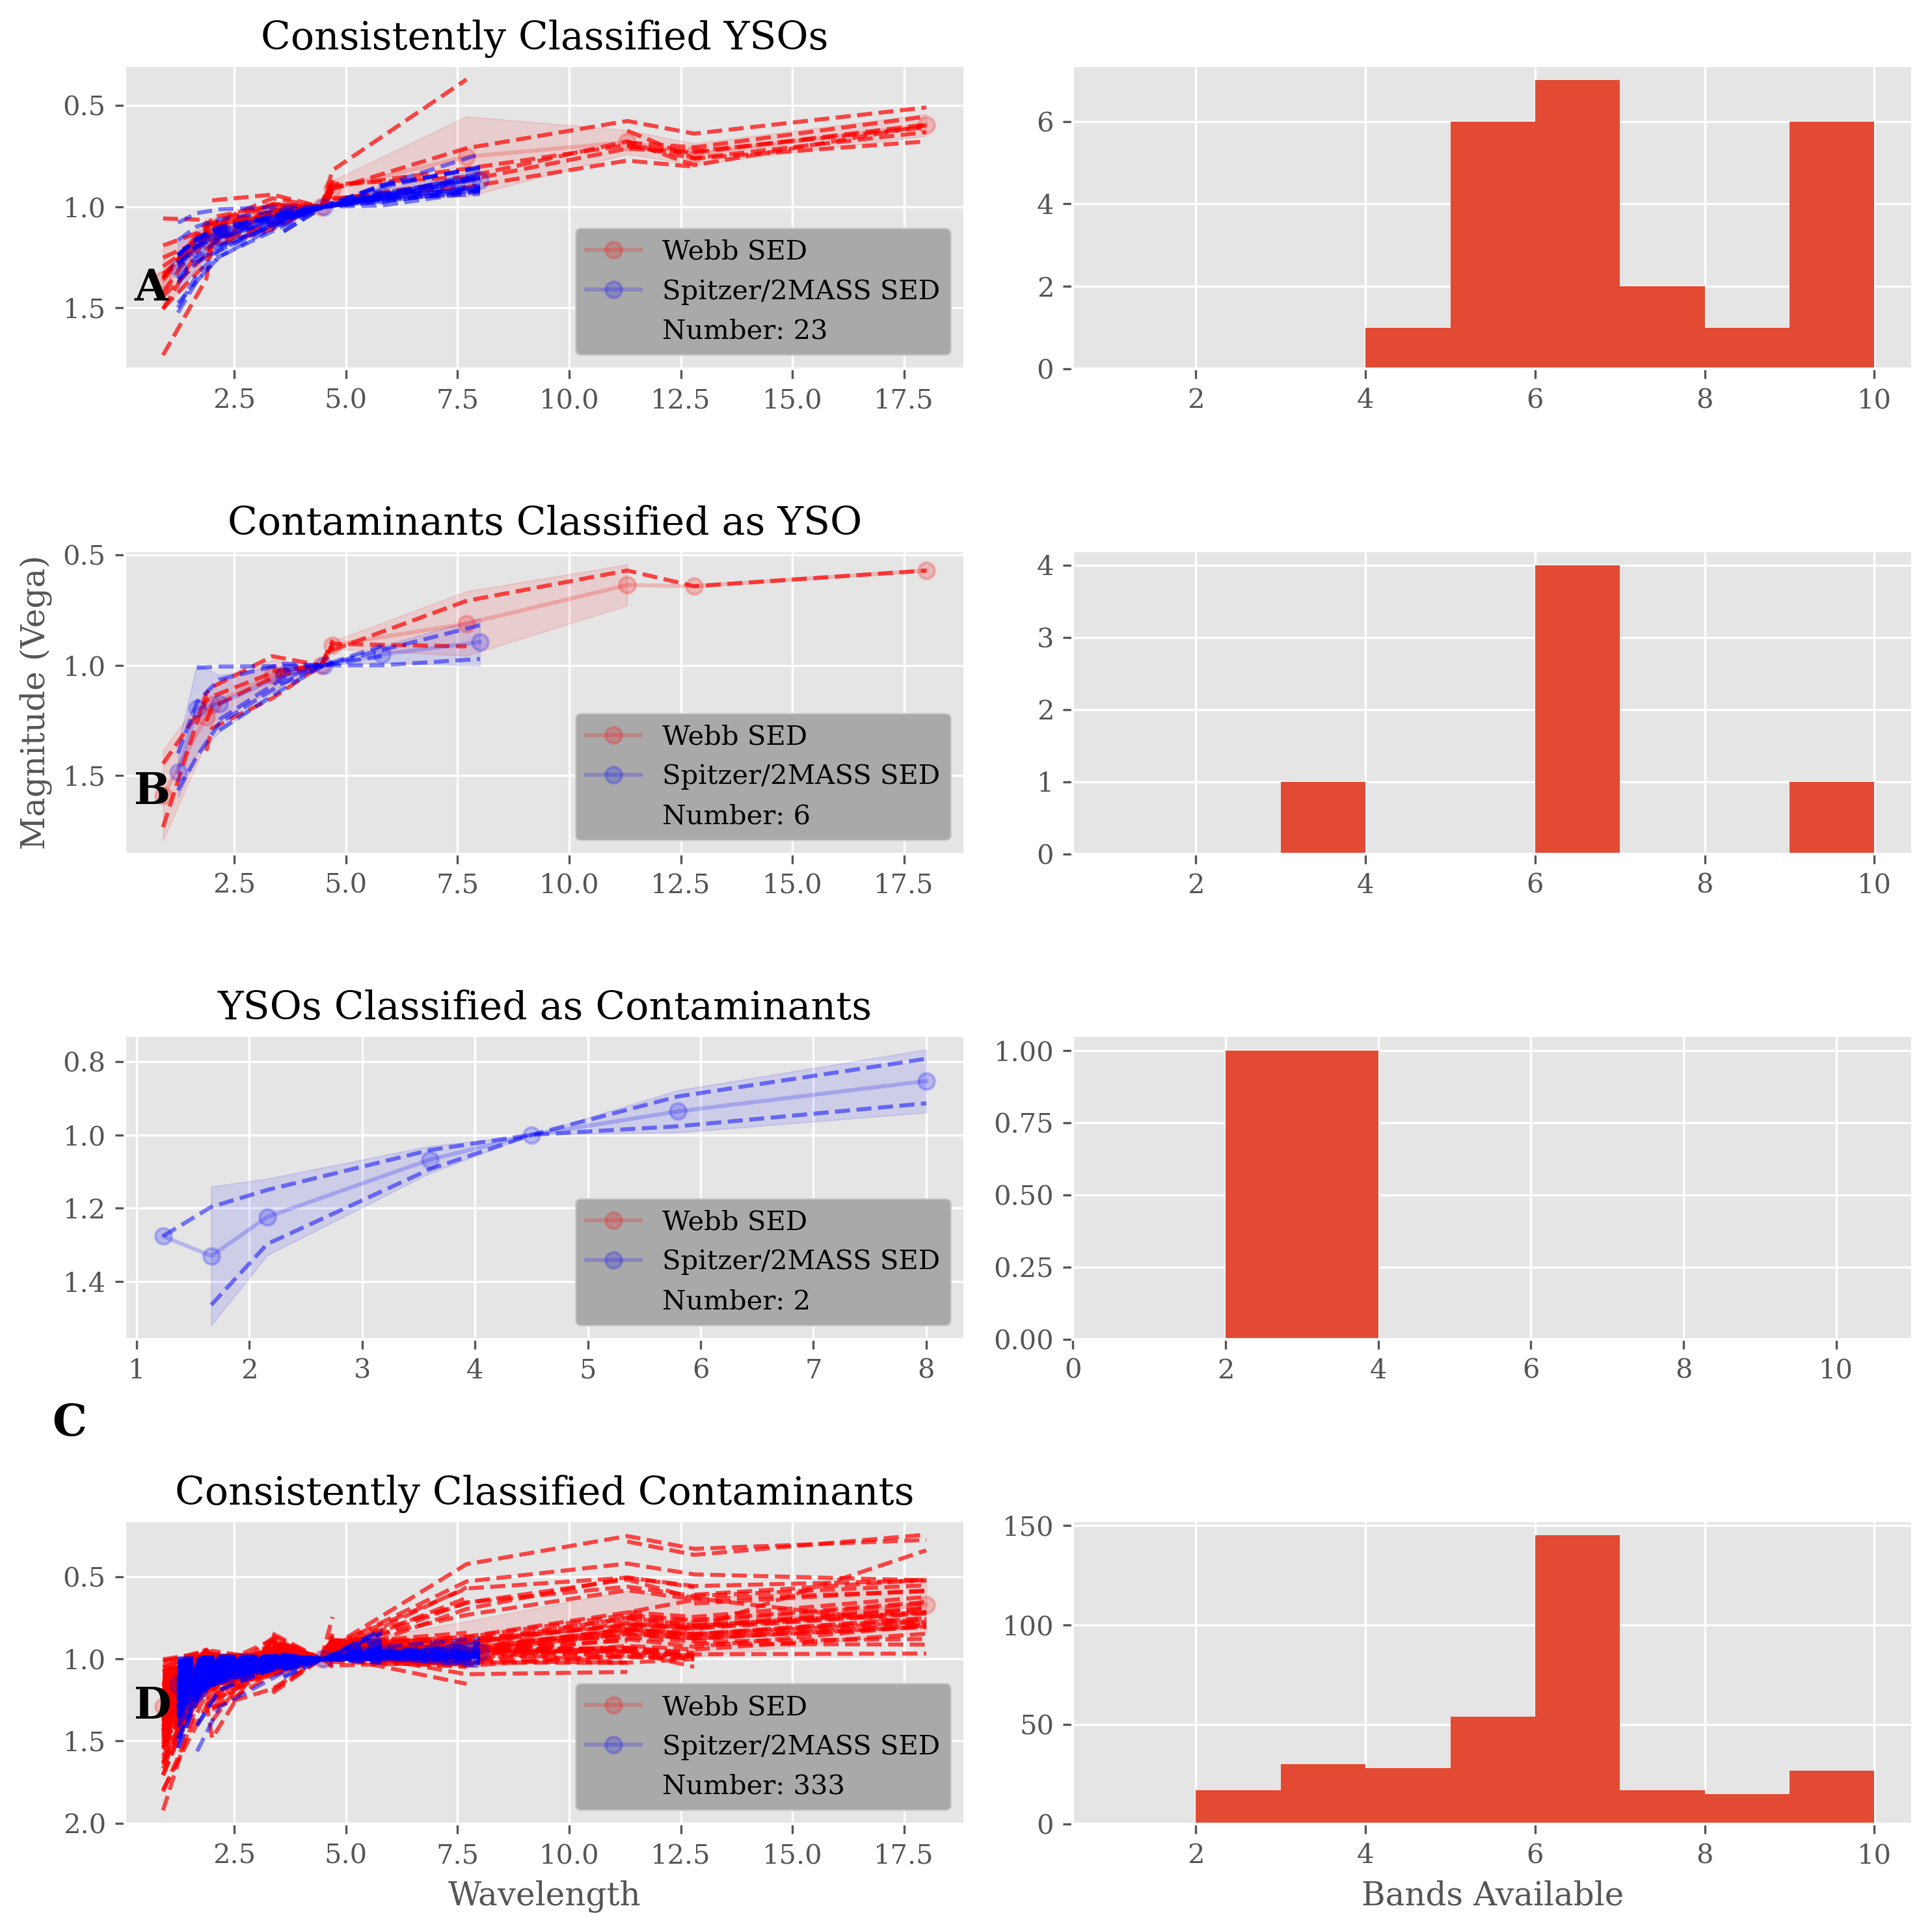

In [58]:
# Normalize to 4.5/4.44 μm

# Plot again
fig, axs = plt.subplots(4,2,figsize=(10,10),dpi=300)

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.style.use('ggplot')
plt.tight_layout()
fig.set_tight_layout(True)
# subfigs = fig.subfigures(1, 2)

axs[0][0].invert_yaxis()
axs[1][0].invert_yaxis()
axs[2][0].invert_yaxis()
axs[3][0].invert_yaxis()
# axs[3][1].invert_yaxis()
axs[0][0] = sed_plot_mu(axs[0][0],a,CC_Webb_Classified_normed,title='Consistently Classified YSOs')
axs[1][0] = sed_plot_mu(axs[1][0],b,CC_Webb_Classified_normed,title='Contaminants Classified as YSO')
axs[2][0] = sed_plot_mu(axs[2][0],c,CC_Webb_Classified_normed,title='YSOs Classified as Contaminants')
axs[3][0] = sed_plot_mu(axs[3][0],d,CC_Webb_Classified_normed,title='Consistently Classified Contaminants')

ylim_a = axs[0][0].get_ylim()[1]
ylim_b = axs[1][0].get_ylim()[1]
ylim_c = axs[2][0].get_ylim()[1]
ylim_d = axs[3][0].get_ylim()[1]
axs[0][0].text(0.25, ylim_a+1, 'A',  fontsize=16, fontweight='bold', va='top',c='k')
axs[1][0].text(0.25, ylim_b+1, 'B',  fontsize=16, fontweight='bold', va='top',c='k')
axs[2][0].text(0.25, ylim_c+1, 'C',  fontsize=16, fontweight='bold', va='top',c='k')
axs[3][0].text(0.25, ylim_d+1, 'D',  fontsize=16, fontweight='bold', va='top',c='k')


axs[0][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[1][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[2][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[3][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
axs[3][0].set_xlabel('Wavelength')
axs[1][0].set_ylabel('Magnitude (Vega)')


axs[0][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in a],bins=np.arange(1,11,1))
axs[1][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in b],bins=np.arange(1,11,1))
axs[2][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in c],bins=np.arange(1,11,1))
axs[3][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in d],bins=np.arange(1,11,1))
axs[2][1].set_xlim(0,11)
axs[3][1].set_xlabel('Bands Available')

plt.savefig('seds_norm.png',dpi=300)

## Table of SPICY Labels, JWST_NUM, Reiter matched

In [63]:
# JWST_NUM

# print('J'+np.array(jwst_spitz_cat.RA)+np.array(jwst_spitz_cat.DEC))
def deg_to_hrminsec(deg):
    deg = deg*u.deg
    h = deg.to(u.hourangle)/u.hourangle
    m = (h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:04.1f}".format(s)
def deghr_to_hrminsec(deg):
    h = deg
    # print(Angle(deg,u.hourangle).hms)
    m = 60-(h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:02d}".format(int(s))

jwst_num = []


for i, r in enumerate(np.array(CC_Webb_Classified.RA)):
    jwst_num.append('J'+deg_to_hrminsec(r)+deghr_to_hrminsec(np.array(CC_Webb_Classified.DEC)[i]))

CC_Webb_Classified["JWST_NUM"] = jwst_num

In [87]:
CC_Webb_Classified.dropna(subset='SPICY')[['SPICY','RA','DEC','JWST_NUM','Class','SPICY_Class']]

SPICY          RA        DEC          JWST_NUM  Class SPICY_Class
4      7461.0  159.250975 -58.592640  J103700.2-583533    0.0   FS       
5      7441.0  159.225224 -58.626385  J103654.1-583734    0.0   ClassI   
13     7428.0  159.203060 -58.634287  J103648.7-583803    0.0   ClassII  
14     7438.0  159.222144 -58.631827  J103653.3-583754    0.0   uncertain
22     7447.0  159.239184 -58.610425  J103657.4-583637    0.0   ClassII  
26     7473.0  159.273631 -58.571905  J103705.7-583418    0.0   FS       
41     7423.0  159.197247 -58.635838  J103647.3-583809    0.0   ClassI   
42     7475.0  159.277075 -58.588171  J103706.5-583517    0.0   ClassII  
44     7476.0  159.277841 -58.572111  J103706.7-583419    0.0   ClassII  
98     7469.0  159.260283 -58.567527  J103702.5-583403    0.0   ClassI   
117    7479.0  159.284966 -58.615221  J103708.4-583654    0.0   ClassII  
120    7477.0  159.278935 -58.615355  J103706.9-583655    0.0   ClassII  
126    7454.0  159.246241 -58.590297  J103659.1-583525    0.0   FS       
137    7435.0  159.218734 -58.623672  J103652.5-583725    0.0   ClassI   
142    7465.0  159.253313 -58.606184  J103700.8-583622    0.0   FS       
144    7464.0  159.252943 -58.595847  J103700.7-583545    0.0   ClassII  
145    7448.0  159.243422 -58.605191  J103658.4-583618    0.0   FS       
151    7444.0  159.236002 -58.616470  J103656.6-583659    0.0   ClassII  
192    7452.0  159.245307 -58.628437  J103658.9-583742    0.0   ClassII  
248    7482.0  159.298706 -58.573474  J103711.7-583424    0.0   ClassII  
256    7467.0  159.258820 -58.615955  J103702.1-583657    0.0   ClassII  
17537  7441.0  159.224903 -58.622119  J103654.0-583719    1.0   ClassI   
22005  7461.0  159.250262 -58.591194  J103700.1-583528    0.0   FS       
22270  7475.0  159.276678 -58.588333  J103706.4-583518    1.0   ClassII  
25075  7423.0  159.196622 -58.636152  J103647.2-583810    0.0   ClassI

In [89]:
len(np.unique(CC_Webb_Classified.dropna(subset='SPICY')[['SPICY']]))

21

In [80]:
idx, sep2d, _ = match_coordinates_sky(sky_1,SkyCoord(CC_Webb_Classified.RA*u.deg, CC_Webb_Classified.DEC*u.deg))
print(np.sort(idx))
CC_Webb_Classified[['JWST_NUM','Class','SPICY_Class','SPICY']].iloc[idx]

[   14    25    83   105   173   256   699   769  1659  1676  1936  1962
  5710  7431 17366 17381 17537 21830 21886 23485 25070 25075 25081]


JWST_NUM  Class SPICY_Class   SPICY
1962   J103642.2-583803    1.0         NaN     NaN
5710   J103648.0-583818    1.0         NaN     NaN
25075  J103647.2-583810    0.0   ClassI     7423.0
25070  J103646.7-583805    1.0         NaN     NaN
1936   J103651.5-583753    1.0         NaN     NaN
105    J103650.5-583752    1.0         NaN     NaN
173    J103651.4-583748    1.0         NaN     NaN
25     J103653.8-583748    0.0         NaN     NaN
83     J103651.5-583710    1.0         NaN     NaN
17366  J103654.3-583626    1.0         NaN     NaN
17381  J103654.5-583619    1.0         NaN     NaN
17537  J103654.0-583719    1.0   ClassI     7441.0
1659   J103653.6-583520    1.0         NaN     NaN
7431   J103653.0-583737    1.0         NaN     NaN
14     J103653.3-583754    0.0   uncertain  7438.0
21886  J103652.7-583804    1.0         NaN     NaN
699    J103653.0-583707    1.0         NaN     NaN
1676   J103651.6-583657    1.0         NaN     NaN
23485  J103652.4-583811    1.0         NaN     NaN
25081  J103654.1-583630    1.0         NaN     NaN
769    J103701.5-583750    1.0         NaN     NaN
256    J103702.1-583657    0.0   ClassII    7467.0
21830  J103653.9-583632    1.0         NaN     NaN

## Notes

kld - divergence metric

Keep 4.5-4.44

Don't forget mags are logarithmic, look at Jy 2.5log(J1/J2)